In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Disable oneDNN optimizations for numerical consistency
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Define dataset path
dataset_path = "../artifacts/data"

# Image settings
img_size = (64, 64)  # Resizing images to 64x64
batch_size = 32  # Number of images per batch

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='categorical',
    subset='training'
)

# Load Validation Data
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

# Get number of classes dynamically
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)
print("Class Labels:", train_generator.class_indices)

# Define the CNN model with L2 Regularization (Weight Decay)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Dynamically set classes
])

2025-04-18 09:32:44.679023: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 09:32:44.705176: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 44400 images belonging to 37 classes.
Found 11100 images belonging to 37 classes.
Number of classes: 37
Class Labels: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, '_': 36}


2025-04-18 09:32:47.315216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-18 09:32:47.335707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-18 09:32:47.337902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')


In [3]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                                                        

In [4]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=500,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/500


2025-04-18 09:32:48.106205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-04-18 09:32:48.271946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-04-18 09:32:48.303802: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x74fbf43a8be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-18 09:32:48.303824: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-18 09:32:48.306480: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-18 09:32:48.379418: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

1388/1388 [==============================] - 22s 15ms/step - loss: 2.8602 - accuracy: 0.2383 - val_loss: 1.8512 - val_accuracy: 0.4625
Epoch 2/500
   5/1388 [..............................] - ETA: 18s - loss: 1.9567 - accuracy: 0.4000 

/home/aryan-dhanuka/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1388/1388 [==============================] - 21s 15ms/step - loss: 1.7389 - accuracy: 0.5053 - val_loss: 2.6749 - val_accuracy: 0.4627
Epoch 3/500
1388/1388 [==============================] - 20s 15ms/step - loss: 1.4090 - accuracy: 0.6411 - val_loss: 1.2733 - val_accuracy: 0.7085
Epoch 4/500
1388/1388 [==============================] - 20s 14ms/step - loss: 1.1998 - accuracy: 0.7394 - val_loss: 0.9356 - val_accuracy: 0.8077
Epoch 5/500
1388/1388 [==============================] - 20s 14ms/step - loss: 1.0790 - accuracy: 0.7963 - val_loss: 1.1552 - val_accuracy: 0.8036
Epoch 6/500
1388/1388 [==============================] - 20s 14ms/step - loss: 0.9777 - accuracy: 0.8366 - val_loss: 0.9448 - val_accuracy: 0.8568
Epoch 7/500
1388/1388 [==============================] - 20s 15ms/step - loss: 0.8861 - accuracy: 0.8680 - val_loss: 0.9054 - val_accuracy: 0.8705
Epoch 8/500
1388/1388 [==============================] - 19s 14ms/step - loss: 0.8277 - accuracy: 0.8860 - val_loss: 0.7595 - val_

In [ ]:
import os
model_save_path = "../artifacts/model/sign_language_model.h5"

# Ensure directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the trained model
model.save(model_save_path)
print(f"✅ Model saved successfully at: {model_save_path}")

✅ Model saved successfully at: /home/aryan-dhanuka/DTI Project/artifacts/model/sign_language_model.h5


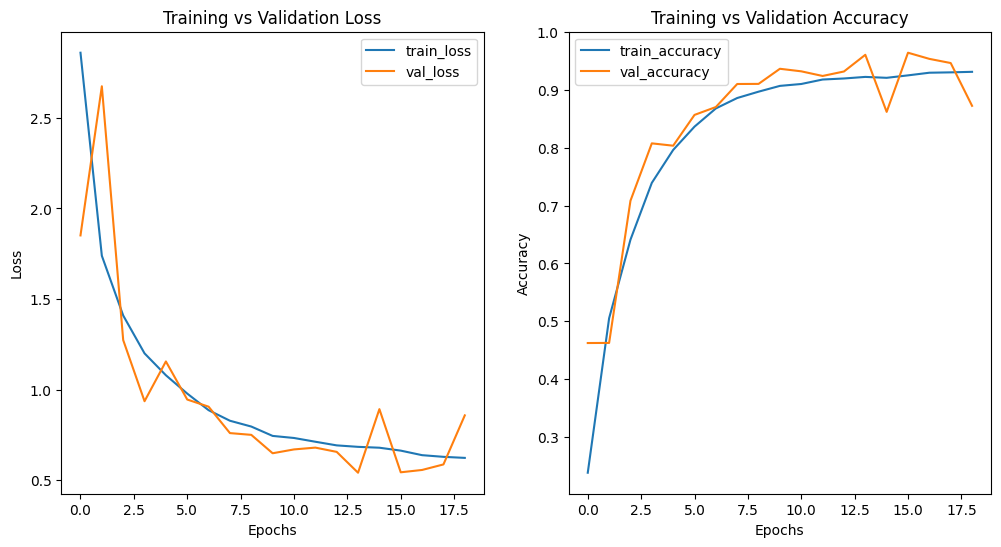

In [6]:
# Plotting training & validation loss and accuracy
plt.figure(figsize=(12, 6))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [7]:
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.4f}")

347/347 [==============================] - 4s 12ms/step - loss: 0.5400 - accuracy: 0.9614
Test Accuracy: 0.9614
